# 1. Overview

This Jupyter notebook focuses on analyzing the sentiment of tweets related to technological products, specifically Apple and Google.

The data is first explored to understand its structure, including the distribution of categorical variables and the handling of missing values. Various preprocessing steps are applied, such as cleaning the tweet text, tokenization, and removing stopwords. A function is developed to identify the brand of the technological product mentioned in each tweet so it will be an aditional feature in our dataset.

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re  # Import regular expressions library

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to C:\Users\Usuario/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2.3 Define global variables

In [2]:
path = '..\data\judge-1377884607_tweet_product_company.csv'

## 3.4 Functions

In [3]:
def plot_categorical_proportions(df):
    """
    Plots bar charts for each categorical variable in a DataFrame, showing the proportion of each category,
    ordered by proportion in descending order. Each bar is labeled with its percentage value and count.

    Inputs:
    df (pd.DataFrame): The DataFrame to analyze.

    Outputs:
    None

    Description:
    This function identifies categorical variables, calculates the proportion and count of each category, sorts them,
    and plots a bar chart for each categorical variable. Labels on the bars display the percentage proportion and
    the count of each category, excluding the 'tweet_text' column.
    """
    # Excluding 'tweet_text' column
    df = df.drop(columns=['tweet_text'])
    
    for col in df.columns:
        # Calculating proportions and counts
        value_counts = df[col].value_counts(normalize=True).sort_values(ascending=False)
        absolute_counts = df[col].value_counts().sort_values(ascending=False)
        percentages = value_counts * 100  # Convert proportions to percentages
        
        # Plotting
        plt.figure(figsize=(10, 6))
        ax = percentages.plot(kind='bar')
        ax.set_title(f'Proportion of Categories in {col}')
        ax.set_ylabel('Percentage')
        
        # Adjusting the y-limit to provide space for the labels
        plt.ylim(0, max(percentages) + 10)  # Increase y-limit by 10 units for better visibility of labels
        
        # Adding percentage and count labels on the bars, positioned above the bar
        for p, count in zip(ax.patches, absolute_counts):
            ax.annotate(f'{p.get_height():.2f}%\n({count})', 
                        (p.get_x() + p.get_width() / 2., p.get_height() + 1),  # Label is placed above the bar
                        ha='center', va='bottom', fontsize=10, color='black')

        plt.tight_layout()  # Ensure the layout fits within the figure bounds
        plt.show()

In [4]:
def plot_grouped_charts(df):
    """
    Creates combined plots for each column in the DataFrame based on their data type, grouped by the 'is_there_an_emotion_directed_at_a_brand_or_product' column.
    For numeric columns, histograms for all statuses are combined in one plot, and boxplots for all statuses are combined in another.
    For categorical columns, grouped bar charts are created.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
    """
    status_col = 'is_there_an_emotion_directed_at_a_brand_or_product'
    unique_statuses = df[status_col].unique()
    colors = plt.get_cmap('tab10')  # Fetches a colormap with distinct colors

    for col in df.columns:
        if col not in [status_col, 'tweet_text']:
            if df[col].dtype in ['int64', 'float64']:  # Numeric Columns
                plt.figure(figsize=(12, 6))
                
                # Histogram for all statuses
                for i, status in enumerate(unique_statuses):
                    sns.histplot(df[df[status_col] == status][col], kde=True, element='step', 
                                 stat='density', label=str(status), color=colors(i))
                
                plt.title(f'Combined Histogram of {col} by {status_col}')
                plt.legend(title=status_col)
                plt.show()
                
                # Boxplot for all statuses
                plt.figure(figsize=(12, 6))
                sns.boxplot(x=status_col, y=col, data=df, palette='tab10')
                plt.title(f'Combined Boxplot of {col} by {status_col}')
                plt.show()
            
            elif df[col].dtype == 'object':  # Categorical Columns
                plt.figure(figsize=(10, 6))
                sns.countplot(data=df, x=status_col, hue=col)
                plt.title(f'Grouped Bar Chart of {status_col} by {col}')
                plt.ylabel('Count')
                plt.xlabel(status_col)
                plt.legend(title=col, loc='upper right')
                plt.xticks(rotation=45)
                plt.show()


In [5]:
def txt_clean(txt):
    """
    Clean and preprocess text data for further analysis.

    Parameters:

        txt (str): The text string that needs to be cleaned and tokenized.

    Returns:

        list: A list of cleaned and tokenized words, where punctuation and special characters are replaced by spaces, text 
        is converted to lowercase, stopwords and Twitter mentions are removed, words with accents are excluded, and empty 
        strings are filtered out.
    
    """
    
    # List of additional strange characters to remove
    strange_chars = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!#Ûª'
    
    sw = stopwords.words('english')
    sw.extend(['link', 'rt', 'get'])
    no_accents_re = re.compile('^[a-z]+$')
    twitter_re = re.compile('[@][a-zA-Z]*')

    # Replace punctuation and strange characters with spaces
    txt = txt.translate(str.maketrans(strange_chars, ' ' * len(strange_chars)))

    # Tokenize the text
    tokens = word_tokenize(txt)

    # Convert to lowercase
    tokens = [w.lower() for w in tokens]
    # Remove @ mentions
    tokens = [w for w in tokens if not twitter_re.match(w)]
    # Remove words with accents
    tokens = [w for w in tokens if no_accents_re.match(w)]
    # Remove stopwords
    tokens = [w for w in tokens if w not in sw]
    # Remove empty strings
    tokens = [w for w in tokens if w]

    return tokens

In [6]:
# Define the function to identify if the tweet is about a Google or Apple product
def identify_product(tweet_text):
    """
    Identify if the tweet is about a Google or Apple product.
    
    Parameters:
    tweet_text (str): The text of the tweet.
    
    Returns:
    str: 'Google' if the tweet mentions a Google product, 'Apple' if the tweet mentions an Apple product,
         'Both' if the tweet mentions both, 'Unknown' if it mentions neither.
    """
    google_keywords = ['google', 'pixel', 'pixels', 'nexus', 'nexuses', 'android', 'androids', 
                       'chromebook', 'chromebooks', 'nest', 'nests', 'stadia', 'stadias']
    apple_keywords = ['apple', 'apples', 'iphone', 'iphones', 'ipad', 'ipads', 'macbook', 
                      'macbooks', 'imac', 'imacs', 'watch', 'watches', 'airpods', 
                      'appstore', 'ios', 'itunes']
    
    # Ensure tweet_text is a string
    if not isinstance(tweet_text, str):
        return 'Unknown'
    
    # Replace "app store" with "appstore" before tokenization
    tweet_text = tweet_text.replace("app store", "appstore")
    
    # Remove all numbers from the tweet text
    tweet_text = re.sub(r'\d+', '', tweet_text)
    
    # Clean the text and obtain tokens
    tokens = txt_clean(tweet_text)
    
    # Check if any keyword exists as a substring within the tokens
    google_mentioned = any(any(keyword in token for keyword in google_keywords) for token in tokens)
    apple_mentioned = any(any(keyword in token for keyword in apple_keywords) for token in tokens)
    
    if google_mentioned and apple_mentioned:
        return 'Both'
    elif google_mentioned:
        return 'Google'
    elif apple_mentioned:
        return 'Apple'
    else:
        return 'Unknown'

In [7]:
def plot_emotion_distribution(df, product_column='product_mention', emotion_column='emotion_type'):
    """
    Plots a bar chart showing the distribution of emotion types by product mention,
    with annotations displaying the counts and percentages.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    product_column (str): The name of the column that contains product mentions. Default is 'product_mention'.
    emotion_column (str): The name of the column that contains emotion types. Default is 'emotion_type'.
    """
    # Calculate the counts and normalize to get percentages
    counts = df.groupby([product_column, emotion_column]).size().reset_index(name='counts')
    total_counts = df[product_column].value_counts().reset_index()
    total_counts.columns = [product_column, 'total']

    # Merge counts with totals to calculate percentages
    counts = counts.merge(total_counts, on=product_column)
    counts['percentage'] = (counts['counts'] / counts['total']) * 100

    # Plotting
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=counts, x=product_column, y='percentage', hue=emotion_column)

    # Annotate each bar with the corresponding count and percentage
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)} ({height:.1f}%)', 
                    xy=(p.get_x() + p.get_width() / 2, height), 
                    xytext=(0, 5),  # Offset label position above the bar
                    textcoords='offset points',
                    ha='center', va='center')
    
    plt.title('Distribution of Emotion Types by Product Mention')
    plt.ylabel('Percentage')
    plt.xlabel('Product Mention')
    plt.xticks(rotation=45)
    plt.legend(title=emotion_column)
    plt.show()


In [8]:
def get_contingency_table_with_percentage_sign(df, product_column='product_mention', emotion_column='emotion_type'):
    """
    Generates a contingency table for the given DataFrame based on product mentions and emotion types,
    showing the proportions as percentages with a percentage sign, rounded to 2 decimal places.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    product_column (str): The name of the column that contains product mentions. Default is 'product_mention'.
    emotion_column (str): The name of the column that contains emotion types. Default is 'emotion_type'.

    Returns:
    pd.DataFrame: A contingency table with proportions (as percentages) of emotion types for each product mention.
    """
    # Create a contingency table with counts
    contingency_table = pd.crosstab(df[product_column], df[emotion_column])

    # Convert counts to proportions by dividing each cell by the row sum and multiply by 100 to get percentages
    contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

    # Round the percentages to 2 decimal places and add the percentage sign
    contingency_table_percentage = contingency_table_percentage.round(2).astype(str) + '%'

    return contingency_table_percentage

## 3.5 Code

### 3.5.1 Exploratory Analysis

#### 3.5.1.1 Looking at the dataset

In [9]:
df_tweets = pd.read_csv(path, encoding='ISO-8859-1')
df_tweets.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [10]:
df_tweets.shape

(9093, 3)

#### 3.5.1.2 Looking at the data types

In [11]:
# Let's start by having a look at the type of each column
df_tweets.dtypes

tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object

#### 3.5.1.3 Null values

In [12]:
# Let's see how the proportion of null values
(df_tweets.isna().sum()/len(df_tweets))*100

tweet_text                                             0.010997
emotion_in_tweet_is_directed_at                       63.807324
is_there_an_emotion_directed_at_a_brand_or_product     0.000000
dtype: float64

### 3.5.2 Descriptive Analysis

All the columns from our dataset are categorical

#### 3.5.2.1 Univaried Analysis

Let's see the Univaried results of the initial dataset without any changes

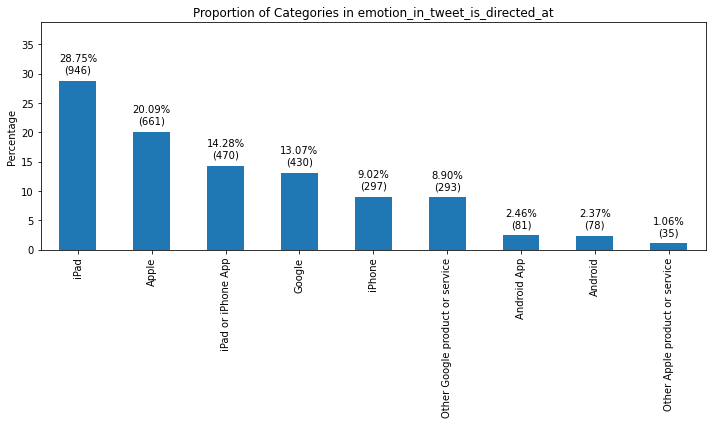

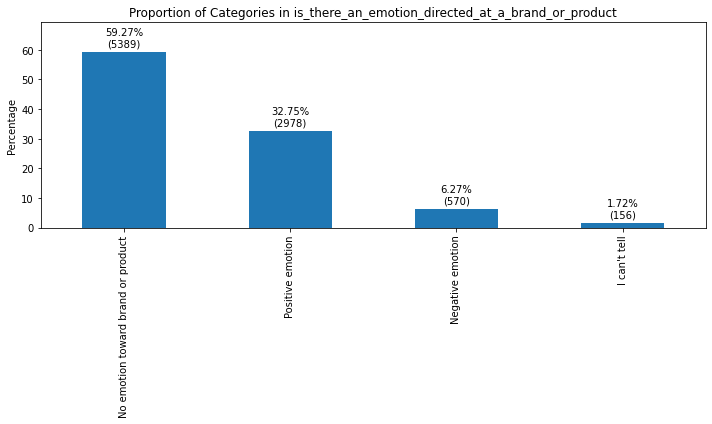

In [13]:
plot_categorical_proportions(df_tweets)

As we can see in the column emotion_in_tweet_is_directed_at, most of the tweets are about iPad or Apple devices. However, there are labels marked as different but that are actually talking about the same category. For example, Android and Android App. 

Regarding the is_there_an_emotion_directed_at_a_brand_or_product variable, we can see that only 39.02% of the tweets have actually either a positive or negative emotion. 

Considering the miss classification in the column emotion_in_tweet_is_directed_at, let's start by looking at the tweets related to the null values of that column.

In [14]:
# Filter rows where the column 'emotion_in_tweet_is_directed_at' is null
null_emotion_tweets = df_tweets[df_tweets['emotion_in_tweet_is_directed_at'].isnull()]

# Display the first 5 records of the 'tweet_text' column where 'emotion_in_tweet_is_directed_at' is null
null_emotion_tweets['tweet_text']

5       @teachntech00 New iPad Apps For #SpeechTherapy...
6                                                     NaN
16      Holler Gram for iPad on the iTunes App Store -...
32      Attn: All  #SXSW frineds, @mention Register fo...
33          Anyone at  #sxsw want to sell their old iPad?
                              ...                        
9087    @mention Yup, but I don't have a third app yet...
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: tweet_text, Length: 5802, dtype: object

Looking at the data, we identify that some labels regarding the device were miss classified. So based on our business problem, we decide to create a function capable of identifying, based on the tweet, which device it's talking about (ie, Google or Apple). And we create a new column with that classification

In [15]:
# Apply the function to the DataFrame and create a new column with the results
df_tweets['product_mention'] = df_tweets['tweet_text'].map(identify_product)

As defined in our business problem, we have decided not to filter any of the labels in the product_mention field because we believe that the values Both and Unknown can provide us with relevant information.

In [16]:
# We will now drop the column emotion_in_tweet_is_directed_at
df_tweets = df_tweets.drop('emotion_in_tweet_is_directed_at', axis=1)

We are going to get a sample of the data just to verify that the sentiments labels are correct. 

In [17]:
# Filter the records for Apple and Google with emotions
apple_tweets = df_tweets[(df_tweets['product_mention'] == 'Apple') & 
                        (df_tweets['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['Positive emotion', 'Negative emotion']))]

google_tweets = df_tweets[(df_tweets['product_mention'] == 'Google') & 
                         (df_tweets['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['Positive emotion', 'Negative emotion']))]

# Get a random sample of 100 records for each product with emotions
apple_sample = apple_tweets.sample(n=100, random_state=42)
google_sample = google_tweets.sample(n=100, random_state=42)

# Combine the two samples
combined_sample = pd.concat([apple_sample, google_sample])

# Display the combined sample
combined_sample

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,product_mention
5455,"RT @mention Apple Pop Up Store for #SXSW, Why ...",Positive emotion,Apple
4473,"No, I didn't get an iPad 2 :( No, I'm not at #...",Positive emotion,Apple
3808,ZOMG its iPad 2 :p RT @mention Look everyone! ...,Positive emotion,Apple
4646,@mention Nice move on Apple #SXSW will be cent...,Positive emotion,Apple
8341,@mention talk about #sxsw and iPad is acceptab...,Positive emotion,Apple
...,...,...,...
609,#smtravel hasn't heard - Google plans to launc...,Positive emotion,Google
2579,Kinda giddy about #TheIndustryParty with #Goog...,Positive emotion,Google
8273,"Google Art Project - like street view, except ...",Positive emotion,Google
3947,Just met Jared at the Android meetup #sxsw. Bi...,Positive emotion,Google


After a rigorus review of each tweet, we conclude that we can trust the is_there_an_emotion_directed_at_a_brand_or_product labels in the dataset. 

Let's rename the column is_there_an_emotion_directed_at_a_brand_or_product to emotion_type

In [18]:
df_tweets.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion_type'}, inplace=True)

In [19]:
df_tweets.head()

,tweet_text,emotion_type,product_mention
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,Google


In [20]:
df_tweets['emotion_type'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion_type, dtype: int64

Let's rename the value 'No emotion toward brand or product' for 'unknown'

In [21]:
# Replace values in column 'emotion_type' where the value is "No emotion toward brand or product" with "no emotion"
df_tweets['emotion_type'] = df_tweets['emotion_type'].replace("No emotion toward brand or product", "no emotion")

We are going to do a replace of every emotion that is not positive to 'no positive' and leave the positive emotions as they are

In [22]:
df_tweets['emotion_type'] = df_tweets['emotion_type'].map(lambda x: 'Positive emotion' if x=='Positive emotion' else 'Not Positive emotion')

Let's see the univaried results after this new updates on df_tweets

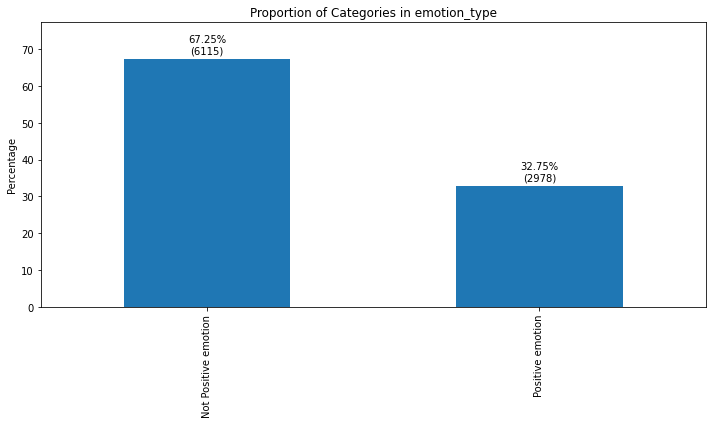

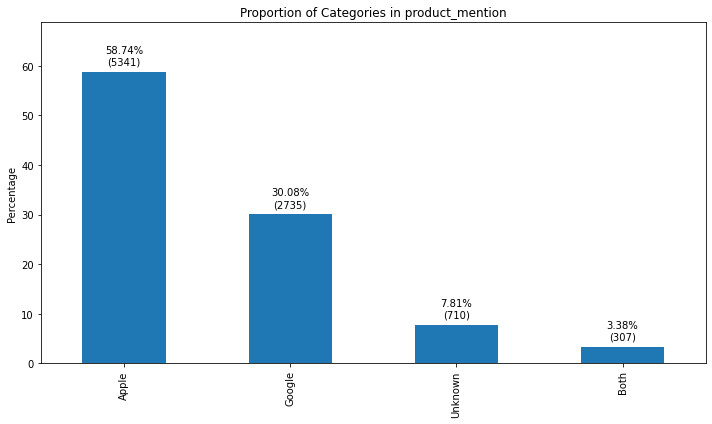

In [23]:
plot_categorical_proportions(df_tweets)

In [24]:
df_tweets.columns

Index(['tweet_text', 'emotion_type', 'product_mention'], dtype='object')

### 3.5.2.2. Multivaried Analysis

Let's see the distribution of the sentiments for each company

**Bar graph**

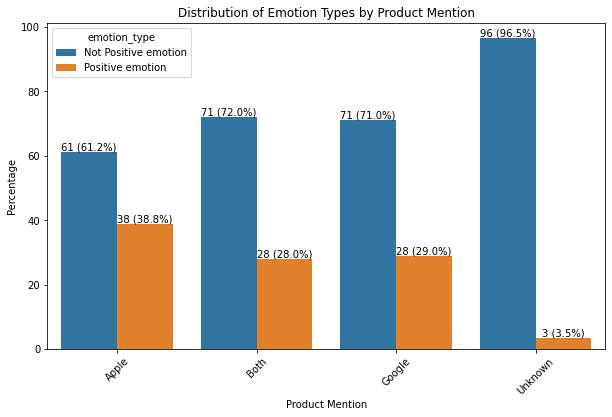

In [25]:
plot_emotion_distribution(df_tweets)

After looking at this graph, we are going to filter the unknowns because it's not giving us much information and it's not in our interests

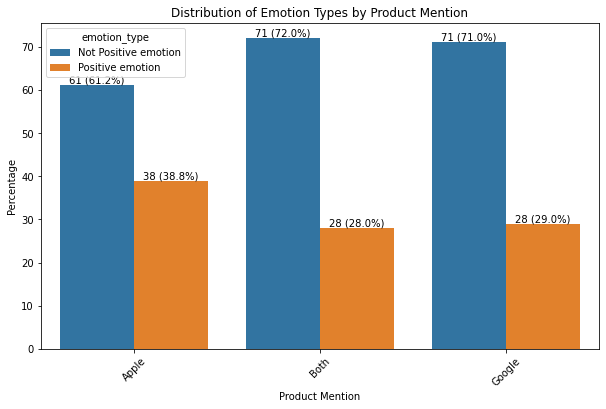

In [26]:
# Filter out rows where product_mention is 'Unknown'
df_tweets = df_tweets[df_tweets['product_mention'] != 'Unknown']

plot_emotion_distribution(df_tweets)

As is observable in the image above, we don't have a problem of imbalance in our data as we usually use 3% as the threshold. 

**Contingency Tables**

In [27]:
contingency_table_percentage = get_contingency_table_with_percentage_sign(df_tweets)

contingency_table_percentage

emotion_type,Not Positive emotion,Positive emotion
product_mention,,
Apple,61.17%,38.83%
Both,71.99%,28.01%
Google,71.01%,28.99%


# 6. Exporting the data

In [28]:
# Export the DataFrame to a CSV file
# index=False ensures that the DataFrame index is not saved as a separate column in the CSV file
df_tweets.to_csv('..\data\df_tweets_clean.csv', index=False)